<a href="https://colab.research.google.com/github/delayudz/ml_course/blob/main/ml_task1_Pavlov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Сгенерирую себе задание

In [5]:
"""from zlib import crc32
import numpy as np

types = ['regression', 'classification']
datasets = {'regression': [{'name': 'Servo Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Servo'}, 
                           {'name': 'Forest Fires Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Forest+Fires'},
                           {'name': 'Boston Housing Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston'}, 
                           {'name': 'Diabetes Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes'}],
            'classification': [{'name': 'Spambase Data Set',
                                'url': 'https://archive.ics.uci.edu/ml/datasets/Spambase'}, 
                               {'name': 'Wine Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine'}, 
                               {'name': 'Breast Cancer Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer'}, 
                               {'name': 'MNIST',
                                'url': 'http://yann.lecun.com/exdb/mnist/'}]}
methods = {'regression': ['Линейная регрессия', 
                          'Перцептрон', 
                          'Надарая-Ватсона',
                          'SVR'],
           'classification': ['Логистическая регрессия', 
                              'Перцептрон', 
                              'k-ближайших соседей',
                              'Метод потенциальных функций',
                              'Метод Парзеновского окна', 
                              'SVM']}
task = dict()
task['mail'] = input(prompt='Enter your mail: ')
task['id'] = crc32(task['mail'].encode('utf-8'))
np.random.seed(task['id'])
task['type'] = np.random.choice(types)
task['dataset'] = np.random.choice(datasets[task['type']])
task['method'] = np.random.choice(
    methods[task['type']], size=3, replace=False).tolist()


task"""
a = 1

Я нагенерил, далее закомменчу код, чтобы он каждый раз не запускался при рестарте.

# 1. Работа с данными

Окей. Значит у меня есть задача классификации. Пропишем библиотеки и посмотрим на данные.

In [6]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist

import torch

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR

from mlxtend.plotting import plot_decision_regions


In [7]:

#try:
    #import google.colab
    #IN_COLAB = True
#except:
    #IN_COLAB = False

#if IN_COLAB:
    #!wget -q -O requirements.txt https://raw.githubusercontent.com/andriygav/MachineLearningSeminars/master/sem2/requirements.txt
    #!pip install -q -r requirements.txt

In [8]:
# Достанем названия признаков из отдельного файла, который я предварительно ручками обработал
headers = []
my_file = open("names.txt","r")

for line in my_file:
    stripped_line = line.strip()
    headers.append(stripped_line)

In [43]:
df = pd.read_csv("data.csv", header=None, names=headers)

In [44]:
df.sample(5, random_state=0)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam or not
991,0.1,0.20,1.01,0.0,0.80,0.80,0.5,0.00,0.8,0.10,0.3,0.70,0.3,0.0,1.61,0.10,0.0,1.11,1.31,0.2,0.70,0.0,0.60,0.10,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.2,0.00,0.1,0.1,0.0,0.0,0.000,0.111,0.000,0.491,0.158,0.015,8.550,669,1351,1
2565,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.000,0.552,0.000,0.000,0.000,0.000,1.000,1,4,0
1906,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,4.54,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,9.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.09,0.0,0.00,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.666,4,15,0
1471,0.0,0.82,0.32,0.0,1.14,0.32,0.0,0.16,0.0,0.65,0.0,2.13,0.0,0.0,0.00,0.16,0.0,0.00,1.47,0.0,1.47,0.0,0.98,0.32,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.16,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.290,0.029,2.257,13,158,1
1813,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.022,0.022,0.019,0.022,0.022,0.022,3.482,5,5902,0


В общем, как написано в приложении к данным, основные признаки тут - это частота встречи слов (48 штук) или символов (6 штук), которые стоят после нижнего подчеркивания в соответствующем названии колонки. Частота выражена в процентах. Затем идут среднее количество непрерывных последовательностей заглавных букв в письме, максимальная длина такой последовательности, и суммарное число заглавных букв в сообщении. Последняя колонка - это класс (1 - спам, 0 - не спам).

In [11]:
print("Размер выборки составляет l = {} объектов".format(df.shape[0]))
print("Количество признаков n = {}".format(df.shape[1] - 1))

Размер выборки составляет l = 4601 объектов
Количество признаков n = 57


In [46]:
df.loc[df['spam or not'] == 0,'spam or not'] = -1

Таким образом, мы имеем множество ответов $y_i = \{-1, 1\}$. Итого, мы имеем задачу классификации на 2 класса.

In [50]:
df.loc[:,'capital_run_length_average':]

,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam or not
0,3.756,61,278,1
1,5.114,101,1028,1
2,9.821,485,2259,1
3,3.537,40,191,1
4,3.537,40,191,1
...,...,...,...,...
4596,1.142,3,88,-1
4597,1.555,4,14,-1
4598,1.404,6,118,-1
4599,1.147,5,78,-1


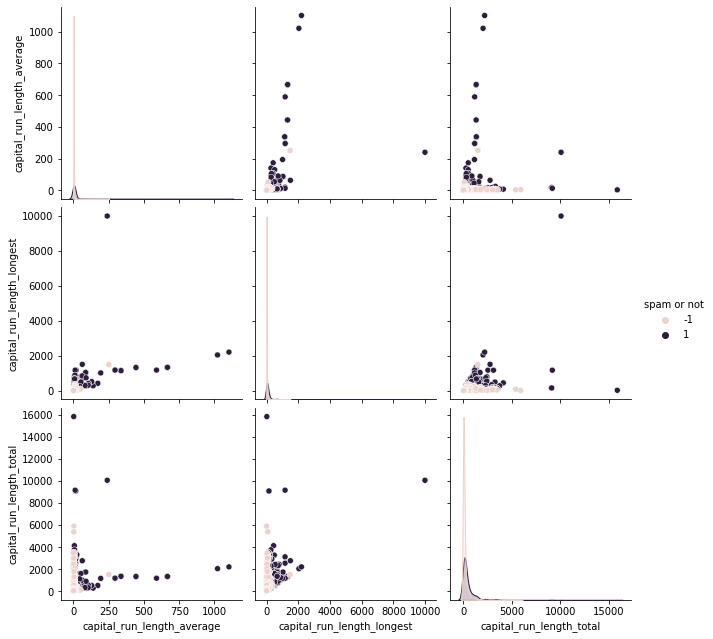

In [52]:
#'''for_pairplot = df.iloc[np.random.randint(len(df), size=100), np.append(np.random.randint(df.shape[1]-2, size=4), df.shape[1]-1)]
for_pairplot = df.loc[:,'capital_run_length_average':]
sns.pairplot(for_pairplot, hue='spam or not', height=3)
plt.show()

В общем, кажется, пэйрплот не дает какого-то наглядного разделения классов. Но посмотрим еще на что-нибудь.

In [54]:
df.columns

Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',


In [76]:
# просто посмотрим на средние значения величин по классам
table = pd.DataFrame(np.zeros((df.shape[1]-1,2)), index=df.iloc[:,:df.shape[1]-1].columns, columns = ['spam', 'not spam'])
table
table['spam'] = df[df['spam or not'] == 1].iloc[:,:df.shape[1]-1].mean(axis=0)
table['not spam'] = df[df['spam or not'] == -1].iloc[:,:df.shape[1]-1].mean(axis=0)
table['% of excess'] = (table['spam'] / table['not spam'] - 1) * 100
table.sort_values(by='% of excess', ascending=False)


,spam,not spam,% of excess
word_freq_3d,0.164672,0.000886,18487.247745
word_freq_000,0.247055,0.007088,3385.770448
word_freq_remove,0.275405,0.009383,2835.131003
word_freq_credit,0.205521,0.007579,2611.752033
char_freq_$,0.174478,0.011648,1397.860751
word_freq_addresses,0.112079,0.008318,1247.466325
word_freq_money,0.212879,0.017138,1142.166650
word_freq_free,0.518362,0.073587,604.422297
word_freq_business,0.287507,0.048346,494.680037
capital_run_length_longest,104.393271,18.214491,473.133077


Построем тепловую карту корреляции признаков.

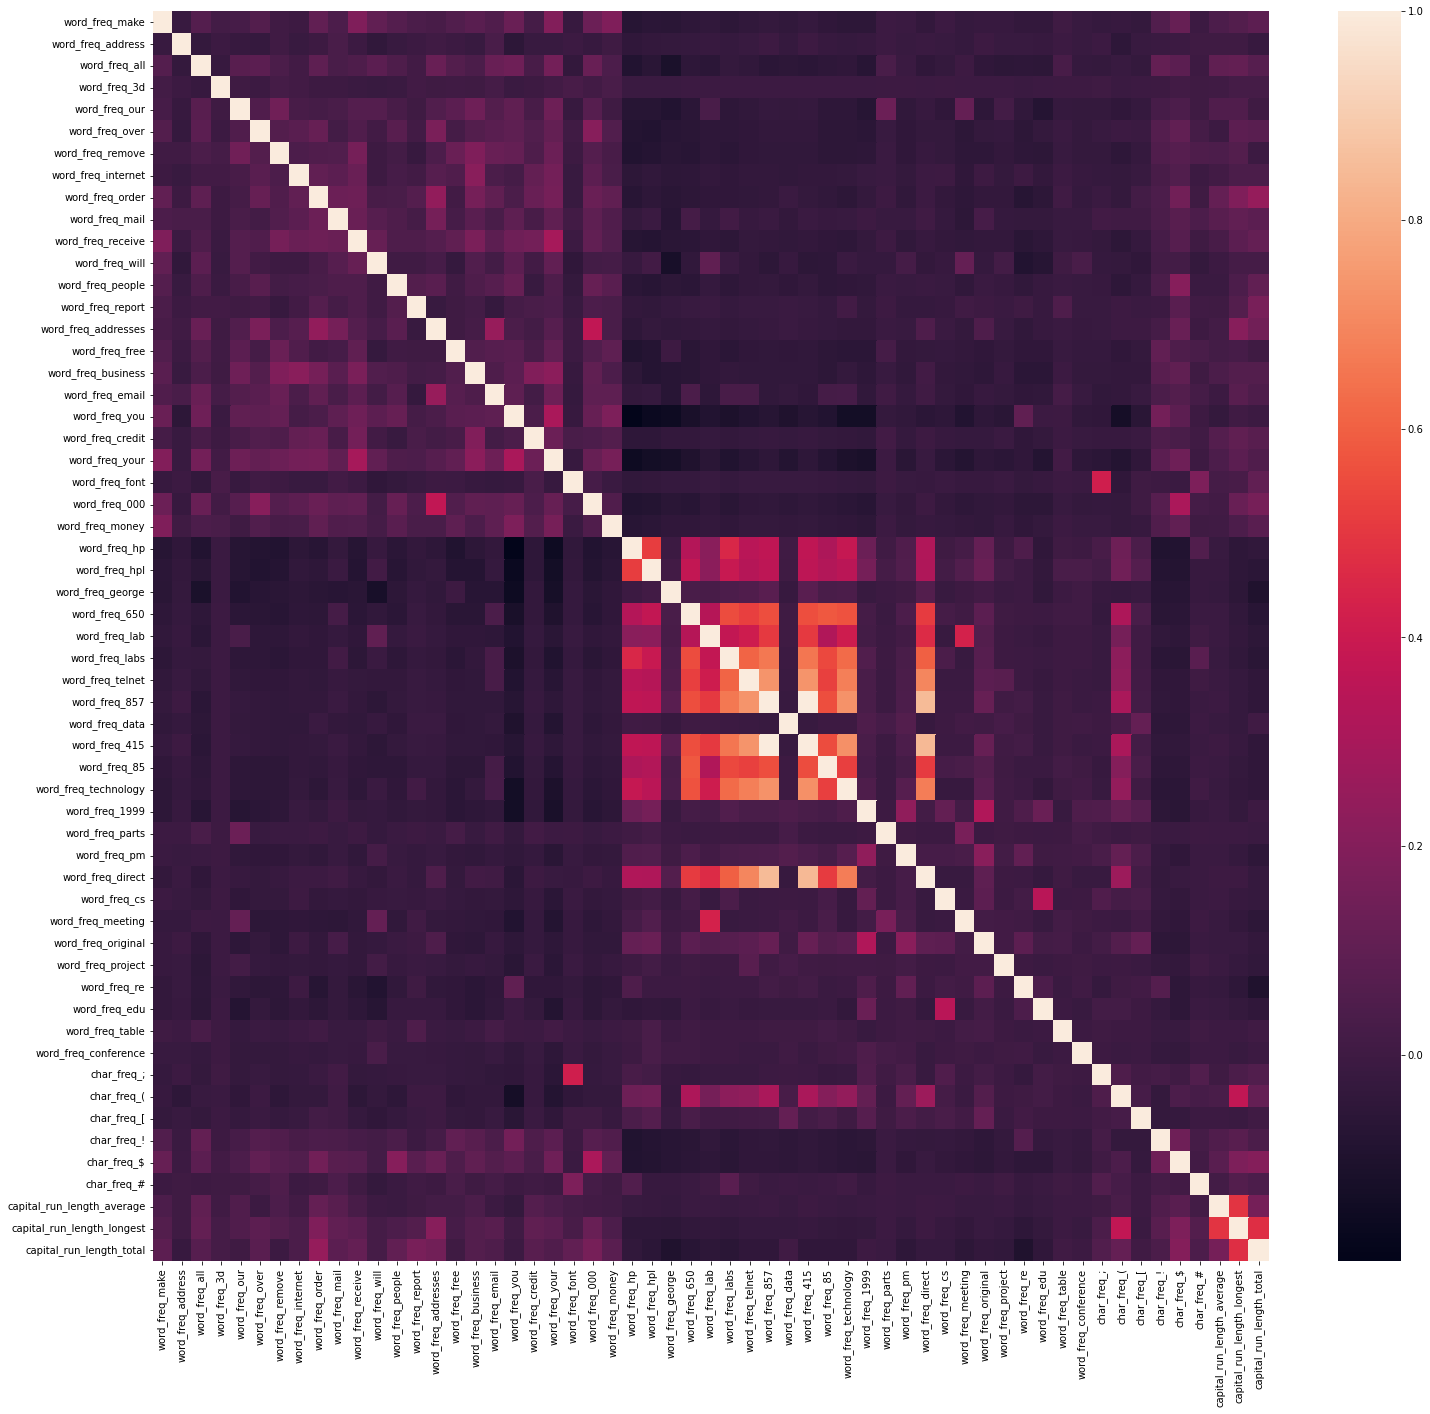

In [36]:
matrix = table.corr(method='pearson')
plt.figure(figsize=(25,23))
sns.heatmap(matrix, annot=False)

Видно, что особо сильно корреляции признаков нигде не наблюдается, кроме как в паре случаев. Исключим один признак - word_freq_857

In [40]:
data = df.drop(labels=['word_freq_857'], axis=1, inpalce=True)